In [1]:
#Distributions and Modules
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch import distributions
import pandas as pd
import numpy as np
from torch import optim

In [2]:
gamma = 0.9

In [36]:
def Normalization(df):
    df.iloc[:,2:]= df.iloc[:,2:].apply(lambda x: ((x-x.mean()) / (x.std())))
    return df

In [37]:
def preprocessing(path):
    df = pd.read_csv(path, header=None, delimiter=' ')
    
    #Normalize the data
    df = Normalization(df)
    
    #Drop the columns which has all values as Nan
    df.dropna(axis=1, how='all', inplace=True)
    
    #Get Rewards for each time step : 0 except last time step where reward is -100
    df['Counter'] = df.index
    lastRowIndex = df.groupby(0).last().Counter.tolist()
    df['reward'] = df['Counter'].apply(lambda x : -100 if x in lastRowIndex else 0 )
    df.drop(columns=['Counter'],inplace=True)
    
    #Rename columns
    df.rename(columns={0: "machine", 1: "time"}, inplace=True)
    
    #Calculate Monte Carlo Value for each row
    df1 = df.groupby('machine').last()[['time']].reset_index()
    df = pd.merge(df, df1, on = 'machine', how = 'left').rename(columns ={'time_x':'time','time_y':'lastTimeStamp'})
    df['MC_Val'] = (gamma ** (df['lastTimeStamp'] - df['time'] )) * (-100)
    df = df.drop(columns='lastTimeStamp')
    
    return df

In [45]:
df = preprocessing("/home/abc/Berkeley/Prof_Ram/CMAPSSData/train_FD001.txt")

## We have added the reward and Val column. We will be using the Val column for the Monte Carlo return gamma**(T-t)  X  -100

## Now lets build the Neural network for the predictron

In [7]:
#Neural network for Observation - Hidden State

In [8]:
class NN_OH(nn.Module):
    def __init__(self, input_size, out_size):
        super(NN_OH,self).__init__()
        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,out_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
input_size  = 24
out_size = 4
net = NN_OH(input_size, out_size)
print(net)

NN_OH(
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


In [10]:
#Neural network for Hidden State - Reward & Value

In [11]:
class NN_reward_val(nn.Module):
    def __init__(self, input_size):
        super(NN_reward_val,self).__init__()
        self.fc1 = nn.Linear(input_size,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,2)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
##Neural Network which will take my current hidden state to the next hidden state

In [13]:
class NN_HH(nn.Module):
    def __init__(self, input_size):
        super(NN_HH,self).__init__()
        self.fc1 = nn.Linear(input_size,32)
        self.fc2 = nn.Linear(32,32)
        self.fc3 = nn.Linear(32,input_size)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [76]:
#Now we have all the required neural networks for the predictron. Lets build the Predictron

class Predictron(nn.Module):
    def __init__(self, obs_size, hid_size):
        super(Predictron,self).__init__()
        
        #Instantiate Neural Network for Observation-Hidden State
        self.fc1 = NN_OH(obs_size, hid_size)
        
        #Instantiate Neural Network for Hidden State - Reward, Value
        self.fc2 = NN_reward_val(hid_size)
        
        #Instantiate Neural Network for Hidden State - Next Hidden State
        self.fc3 = NN_HH(hid_size)
        
    def forward(self, x):
        #Predictron core will output the value estimate for the current observation. We will input x (observation) 
        #and get value estimate. This implementation is for a k-step return which can be extended to TD(lambda) return
        
        #First step: Get the Hidden state for the current observation
        
        x = self.fc1(x)
        
        #Now we keep track of rewards for the k-step return
        k=10
        gamma = 0.9 #Discount Factor
        reward = self.fc2(x)[:,0].reshape(-1,1)
        #print(reward.shape)
        for i in range(k-1):
            #Take the next step
            x = self.fc3(x)
            reward += (gamma**(i+1))*(self.fc2(x)[:,0].reshape(-1,1))
        
        val_kth = (gamma**k)*self.fc2(self.fc3(x))[:,1].reshape(-1,1)
        
        return reward+val_kth
            
        

In [77]:
x = torch.tensor(df.iloc[:, 2:-2].values).float()

In [78]:
x.shape

torch.Size([20631, 21])

In [79]:
y_target = torch.tensor(df.iloc[:,-1].values).float()
y_target = y_target.reshape(-1,1)

In [80]:
y_target.shape

torch.Size([20631, 1])

In [81]:
core = Predictron(x.shape[1], 4)
optimizer = optim.Adam(core.parameters(), lr = 1e-3) 

In [82]:
for p in core.parameters():
    print(p)

Parameter containing:
tensor([[ 0.0529, -0.0134,  0.0320,  ...,  0.0928, -0.0601, -0.0638],
        [-0.0945, -0.2174,  0.1489,  ...,  0.1882, -0.1065,  0.1540],
        [-0.0848,  0.0896, -0.0046,  ..., -0.1973, -0.0250,  0.0705],
        ...,
        [-0.2175,  0.0305,  0.0459,  ...,  0.0093, -0.1903, -0.0921],
        [-0.0343, -0.1804, -0.1719,  ..., -0.0713,  0.2065, -0.1061],
        [-0.1558, -0.1124,  0.1928,  ...,  0.1399,  0.1953, -0.0334]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0266,  0.1352,  0.0440,  0.1105, -0.0898, -0.0070, -0.1447,  0.1869,
        -0.1259, -0.0770,  0.2137,  0.1404,  0.0502,  0.1938,  0.0266,  0.0807,
        -0.0117,  0.0088, -0.1332,  0.1185, -0.1484,  0.1223, -0.0715, -0.0257,
        -0.0677, -0.0277, -0.1884, -0.0921, -0.0570, -0.0977,  0.0804, -0.1446,
        -0.0738,  0.0603, -0.1062,  0.0462, -0.0069,  0.0982, -0.0474, -0.1804,
        -0.0150,  0.0770, -0.1904, -0.1325,  0.0468, -0.0154,  0.1298, -0.0058,
         0.0418

In [83]:
loss_fn = nn.MSELoss()

In [84]:
n_epochs = 30 # or whatever
batch_size = 128 # or whatever
losses=[]
for epoch in range(n_epochs):

    # x is our input
    permutation = torch.randperm(x.size()[0])

    for i in range(0,x.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x[indices], y_target[indices]

        # in case you wanted a semi-full example
        outputs = core.forward(batch_x)
        loss = loss_fn(outputs,batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print("Loss after:"+str(epoch)+" iterations is :"+ str(loss))

Loss after:0 iterations is :tensor(12.6439, grad_fn=<MseLossBackward>)
Loss after:1 iterations is :tensor(11.5024, grad_fn=<MseLossBackward>)
Loss after:2 iterations is :tensor(12.6352, grad_fn=<MseLossBackward>)
Loss after:3 iterations is :tensor(1.0436, grad_fn=<MseLossBackward>)
Loss after:4 iterations is :tensor(3.1699, grad_fn=<MseLossBackward>)
Loss after:5 iterations is :tensor(5.4155, grad_fn=<MseLossBackward>)
Loss after:6 iterations is :tensor(14.8636, grad_fn=<MseLossBackward>)
Loss after:7 iterations is :tensor(25.5870, grad_fn=<MseLossBackward>)
Loss after:8 iterations is :tensor(46.7553, grad_fn=<MseLossBackward>)
Loss after:9 iterations is :tensor(44.2542, grad_fn=<MseLossBackward>)
Loss after:10 iterations is :tensor(15.5817, grad_fn=<MseLossBackward>)
Loss after:11 iterations is :tensor(8.3600, grad_fn=<MseLossBackward>)
Loss after:12 iterations is :tensor(0.1483, grad_fn=<MseLossBackward>)
Loss after:13 iterations is :tensor(41.9243, grad_fn=<MseLossBackward>)
Loss af

Text(0, 0.5, 'Loss')

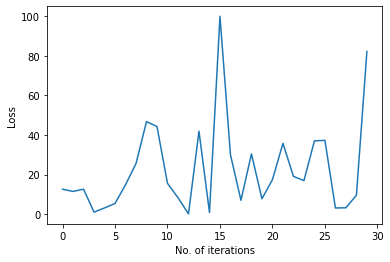

In [85]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("No. of iterations")
plt.ylabel("Loss")

In [86]:
for p in core.parameters():
    print(p)

Parameter containing:
tensor([[ 0.0586, -0.0120, -0.1053,  ...,  0.0840, -0.0587, -0.0737],
        [-0.0842, -0.1852, -0.0152,  ...,  0.1579, -0.0767,  0.1621],
        [-0.0634,  0.1605,  0.0998,  ..., -0.2218, -0.0656, -0.0085],
        ...,
        [-0.1759,  0.0190, -0.0791,  ...,  0.0885, -0.2136, -0.1379],
        [-0.1062, -0.2083,  0.0666,  ..., -0.1182,  0.1592, -0.1306],
        [-0.0888, -0.1077,  0.0879,  ...,  0.2008,  0.1673, -0.0871]],
       requires_grad=True)
Parameter containing:
tensor([-0.1107, -0.0290,  0.1483,  0.0249, -0.1959,  0.0527, -0.2419,  0.0538,
        -0.2712, -0.1888,  0.0980,  0.3665,  0.2266,  0.0654,  0.1612, -0.0082,
         0.1656,  0.2458,  0.2162,  0.3557, -0.2545,  0.0130, -0.1783,  0.0829,
        -0.1683, -0.1433, -0.2849, -0.0178,  0.1240, -0.2105, -0.0588, -0.2599,
         0.1025, -0.0369, -0.1109, -0.0807, -0.1442,  0.2374,  0.0537,  0.0667,
         0.0128, -0.0573, -0.3065, -0.2433, -0.0472,  0.1636,  0.1771, -0.1050,
         0.1224

In [87]:
sample = df.iloc[190:200,2:-2]
sample = torch.tensor(sample.values).float()
sample.shape

predict = core.forward(sample)

In [88]:
predict

tensor([[-60.6324],
        [-70.7927],
        [  0.3685],
        [  0.5835],
        [  0.1920],
        [  0.5596],
        [  0.2232],
        [  0.4025],
        [  0.3756],
        [  0.4399]], grad_fn=<AddBackward0>)

In [89]:
y_target[190:200,:]

tensor([[-9.0000e+01],
        [-1.0000e+02],
        [-8.1914e-12],
        [-9.1015e-12],
        [-1.0113e-11],
        [-1.1236e-11],
        [-1.2485e-11],
        [-1.3872e-11],
        [-1.5414e-11],
        [-1.7126e-11]])